# Hospital Stay Predictions

This notebook uses hospital patient records to predict the length of a patients stay at time of admission. It is possible to have multiple records per patient

The notebook is layed out as follows:

1. Data Exploration & Preparation
2. Diagnostic analysis
3. Predictive analysis
4. Prescriptive analysis
5. Transparency & explainability

## 1. Data Exploration & Preparation

In this section the data set is cleaned and its format prepared for processing.

In [216]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
from helpers.plots import *
import os

In [217]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


#### Load data

In [218]:
# Get data path
DIR = os.getcwd() # current working directory
DATA_PATH = os.path.join(DIR,"data","hospital_stay_data.csv")

# Load data
df = pd.read_csv(DATA_PATH)

#### Data Preview

In [219]:
num_records = df.shape[0]

print(f"Number of Features: {df.shape[1]}")
print(f"Number of Records : {num_records}")
print("Data preview: \n")
df.head()

Number of Features: 18
Number of Records : 318438
Data preview: 



,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50


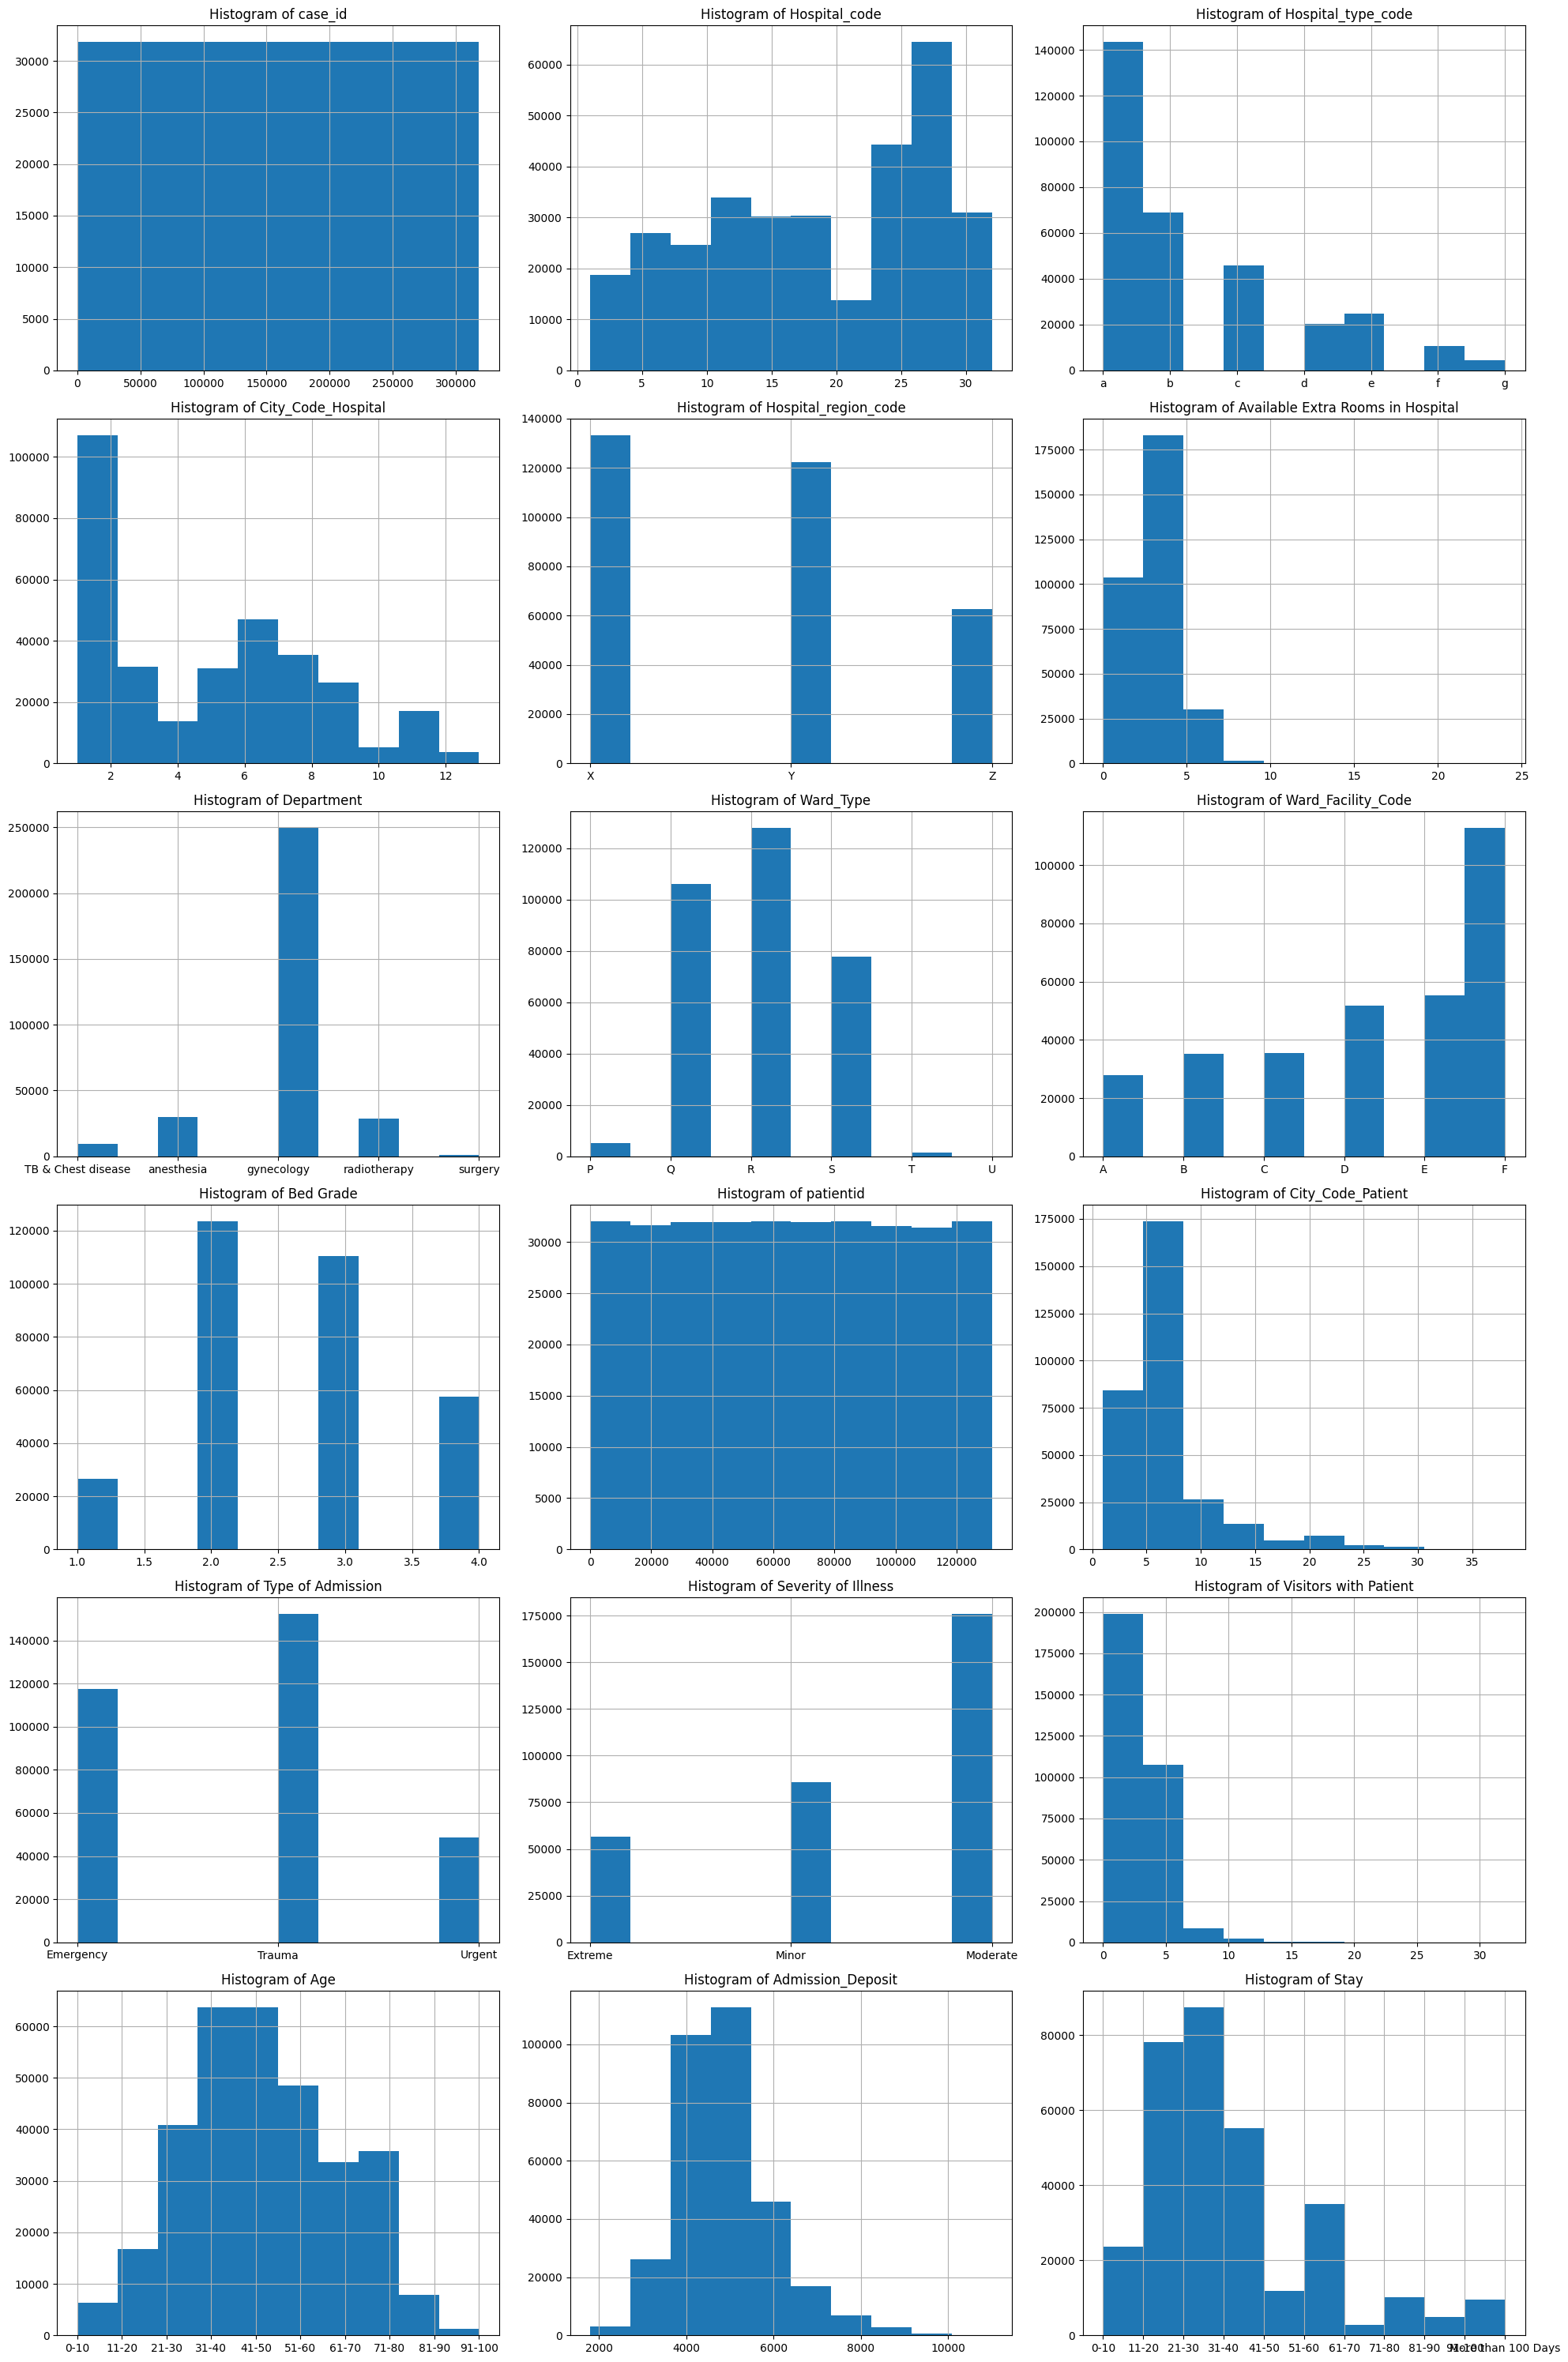

In [220]:
# View histogram of data
plot_histograms(df,3)

In [221]:
# Check contiuous variable types are correct
cont_features = ["Bed Grade", "City_Code_Patient"]
for feature in cont_features:
    diff = np.sum(df[feature] - np.floor(df[feature]))
    if diff == 0:
        print(f"- {feature}: integer values" )
    else: 
        print(f"- {feature}: continuous values" )

- Bed Grade: integer values
- City_Code_Patient: integer values


#### Data Cleaning & Handling Missing Data

In [222]:
# Create lists based on column types
index = "case_id" # unique record identifier 
drop_cols = ["patientid"] # columns to remove 
cont_cols = ["Admission_Deposit"] # columns with continuous vars
int_cols  = ["Available Extra Rooms in Hospital", "Bed Grade", "City_Code_Patient", "Visitors with Patient"] # columns with integer vars
ord_cols  = ["Severity of Illness", "Age", "Stay"] # columns with ordinal categorical vars
nom_cols  = ["Hospital_code", "Hospital_type_code", "City_Code_Hospital", "Hospital_region_code", "Department", "Ward_Type", "Ward_Facility_Code", "Type of Admission"] # columns with nominal categorical vars --> dummy encoding (ensure not too many categories)

In [223]:
# Reset index
df.set_index(index)

# Check for Nan values 
print("Columns containing Nan values: ", [i for i in df.columns if df[i].isna().any()])

Columns containing Nan values:  ['Bed Grade', 'City_Code_Patient']


In [224]:
# Fill City_Code_Patient using another existing record for that patient
City_Code_Patient_dict = df[["patientid","City_Code_Patient"]].dropna().drop_duplicates(inplace=False).set_index("patientid").to_dict() # dict of patient id and their city codes

for i in range(df.shape[0]): # for each row of data
    if np.isnan(df.iloc[i]["City_Code_Patient"]) and df.iloc[i]["patientid"] in City_Code_Patient_dict.keys(): #if the city code is missing and their is another patient record to fill from
        df.iloc[i]["City_Code_Patient"] = City_Code_Patient_dict[df.iloc[i]["patientid"]]


# Drop records with empty values
df.dropna(inplace=True)
print("Columns containing Nan values: ", [i for i in df.columns if df[i].isna().any()])  

Columns containing Nan values:  []


In [225]:
# Drop unnecessary columns
df_clean = df.drop(drop_cols, axis=1).set_index(index)
clean_shape = df_clean.shape

# Correct variable types
for col in cont_cols:
    df_clean[col] = df_clean[col].astype(float) #ensure continuous vars are floats 
for col in int_cols:
    df_clean[col] = df_clean[col].astype(int) #ensure discrete vars are ints
for col in nom_cols:
    df_clean[col] = df_clean[col].astype(str) #ensure nominal vars are strings
    
df_clean.dtypes

Hospital_code                         object
Hospital_type_code                    object
City_Code_Hospital                    object
Hospital_region_code                  object
Available Extra Rooms in Hospital      int64
Department                            object
Ward_Type                             object
Ward_Facility_Code                    object
Bed Grade                              int64
City_Code_Patient                      int64
Type of Admission                     object
Severity of Illness                   object
Visitors with Patient                  int64
Age                                   object
Admission_Deposit                    float64
Stay                                  object
dtype: object

#### Data Encoding - Ordinal


In [226]:
# Check number of unique categories
print("Ordinal features and their cardinality")
for ord in ord_cols:
    print("\t -",ord, df_clean[ord].nunique())

Ordinal features and their cardinality
	 - Severity of Illness 3
	 - Age 10
	 - Stay 11


In [227]:
# Encode severity of illness
sev_mapping = {'Minor':0, 'Moderate':1, 'Extreme':2} #set ordering
df_clean["Severity of Illness"] = df_clean["Severity of Illness"].replace(sev_mapping)
    
# Encode age
age_enc = LabelEncoder()
df_clean["Age"] = age_enc.fit_transform(df_clean["Age"])
    
# Encode age
stay_enc = LabelEncoder()
df_clean["Stay"] = stay_enc.fit_transform(df_clean["Stay"])

# Print encodings 
print(df_clean[ord_cols])
print(df[ord_cols])

         Severity of Illness  Age  Stay
case_id                                
1                          2    5     0
2                          2    5     4
3                          2    5     3
4                          2    5     4
5                          2    5     4
...                      ...  ...   ...
318434                     1    4     1
318435                     1    8     3
318436                     0    7     1
318437                     0    1     1
318438                     0    1     0

[313793 rows x 3 columns]
       Severity of Illness    Age   Stay
0                  Extreme  51-60   0-10
1                  Extreme  51-60  41-50
2                  Extreme  51-60  31-40
3                  Extreme  51-60  41-50
4                  Extreme  51-60  41-50
...                    ...    ...    ...
318433            Moderate  41-50  11-20
318434            Moderate  81-90  31-40
318435               Minor  71-80  11-20
318436               Minor  11-20  11-20
31

C:\Users\sian_\AppData\Local\Temp\ipykernel_29720\2670215756.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean["Severity of Illness"] = df_clean["Severity of Illness"].replace(sev_mapping)


#### Cardinality of Nominal Features

In [228]:
print("Nominal features and their cardinality")
for nom in nom_cols:
    print("\t -",nom, df_clean[nom].nunique())

Nominal features and their cardinality
	 - Hospital_code 32
	 - Hospital_type_code 7
	 - City_Code_Hospital 11
	 - Hospital_region_code 3
	 - Department 5
	 - Ward_Type 6
	 - Ward_Facility_Code 6
	 - Type of Admission 3


#### Check data loss due to cleaning

In [229]:
# Assess data loss due to cleaning
print(f"After cleaning {round(df_clean.shape[0]*100/num_records,1)}% of the data remains")

After cleaning 98.5% of the data remains


## 2. Diagnostic Analysis

#### Feature Relationship Analysis

1. **Kendall's Tau Correlation**
is used as it can assess the relationship between the features and the target variable "Stay". The null hypothesis assumes that there is no monotonic relationship between the two variables. It was chosen because:
    - does not assume normally distributed data ( is non-parametric)
    - less sensitive to tied ranks 
    - assumptions:
        - ordinal or continuous data
        - monotonic relationship between variables (not strict)

1. **Cramer's V**
is used to determine the strength of relationship between 2 categorical variables. It uses the Chi^2 statistic to produce a normalised coeffecient in (0,1) which allows for comparison across the entrie table.
    - applicable to tables  bigger than 2x2
    - assumptions:
        - categorical data
        - mutually exclusive levels or categories
        - frequency in each cell is at least 5 in 80% of cells
The Chi^2 statistic tests for independence of two categories.


In both cases alpha = 0.05

#### Continuous & Ordinal Correlation

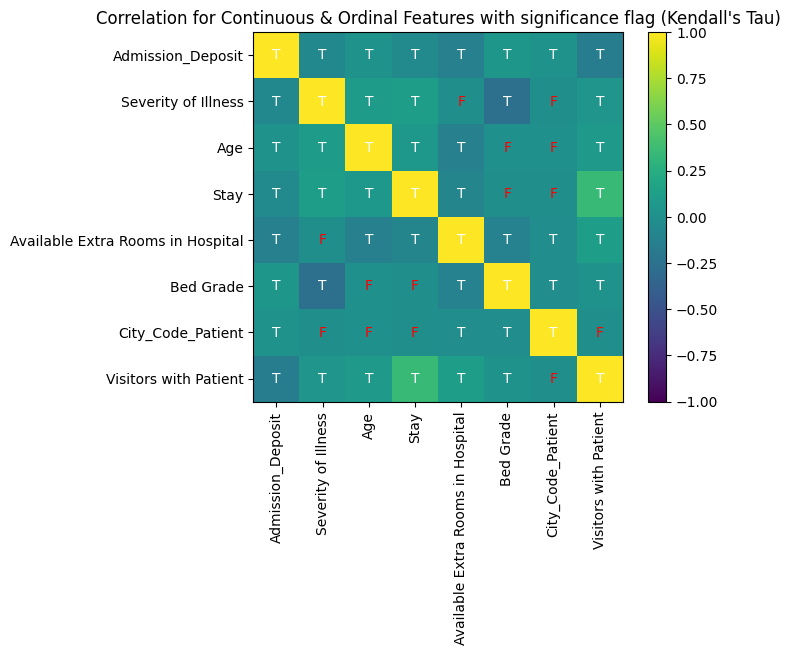

Features to remove:  ['Bed Grade', 'City_Code_Patient']


In [230]:
from scipy import stats
alpha = 0.05

# Compute Kendall's Tau Correlation 
kendall_cols = cont_cols + ord_cols + int_cols
kendalls_corr = pd.DataFrame(index=kendall_cols, columns=kendall_cols)          # to store corr
significance_matrix = pd.DataFrame(index=kendall_cols, columns=kendall_cols)    # to store p_value

for col1 in kendall_cols:
    for col2 in kendall_cols:
        tau, p_value = stats.kendalltau(df_clean[col1], df_clean[col2])
        kendalls_corr.loc[col1, col2] = tau
        significance_matrix.loc[col1, col2] = p_value

# Plot correlation as heatmap
plt.imshow(kendalls_corr.astype(float), vmin=-1, vmax=1, cmap='viridis')
plt.colorbar()
plt.xticks(range(len(kendall_cols)),labels=kendall_cols, rotation=90)
plt.yticks(range(len(kendall_cols)),labels=kendall_cols, rotation=0)
plt.title("Correlation for Continuous & Ordinal Features with significance flag (Kendall's Tau)")

# Overlay the significance of correlation as text
to_drop = []
for i,col1 in enumerate(kendall_cols):
    for j,col2 in enumerate(kendall_cols):
        sig = significance_matrix.loc[col1, col2] # get significance
    
        # Annotate the significance text in the heatmap
        if sig <= alpha/2: # divide alpha by two since a two tail test was used
            plt.text(j, i, "T", ha='center', va='center', color='white', fontsize=10)
        else:
            plt.text(j, i, "F", ha='center', va='center', color='red', fontsize=10)
            if col1 == "Stay":
                to_drop +=[col2]

# show plot
plt.show()
print("Features to remove: ", to_drop)

The results show that:
* "Visitors with Patient" is the best indicator for the target variable "Stay". 
* most features show a weak positive relationship with the target variable "Stay"
* there is some weak correlation between features
* the "Bed Grade" and "City_Code_Patient" features does not have a significant relationship with the target variable "Stay" and should be removed

In [231]:
print("Absolute Kendall's tau values for significant features and Stay")
print()
print(kendalls_corr.drop(to_drop)["Stay"].abs().sort_values(ascending=False))

Absolute Kendall's tau values for significant features and Stay

Stay                                      1.0
Visitors with Patient                0.349825
Severity of Illness                  0.110118
Available Extra Rooms in Hospital    0.089261
Age                                  0.069873
Admission_Deposit                    0.040775
Name: Stay, dtype: object


#### Nominal Features

In [232]:
# Check frequency at least 5 for nominal columns
count = 0
for col in nom_cols+["Stay"]:
    value_counts = df[col].value_counts() # get count of each value
    
    # Check if count less than 5
    if any(value_counts < 5):
        count += 1
        
assert count==0 # All categories have a frequency of at least 5, thus Chi squared and Cramers V can be used    

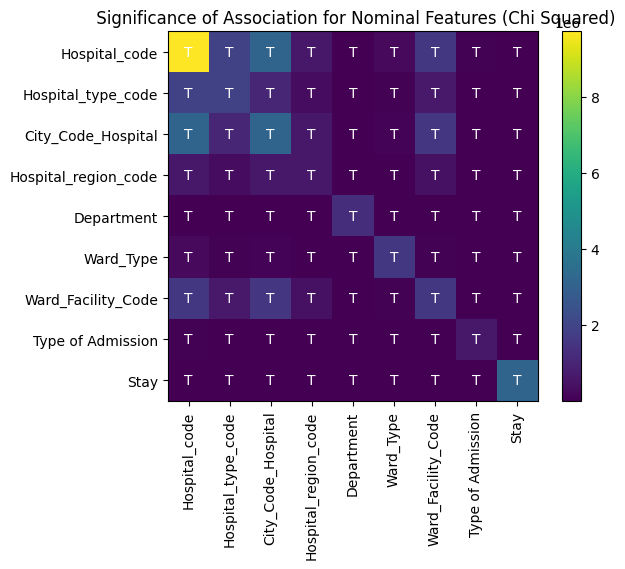

Features to remove:  ['Bed Grade', 'City_Code_Patient']


In [233]:
#Chi-Squared statistic for nominal variables
chi2_matrix   = pd.DataFrame(index=nom_cols, columns=nom_cols)          # to store chi^2 val
chi2_sig_matrix = pd.DataFrame(index=nom_cols, columns=nom_cols)        # to store p_value
chi2_dof_matrix = pd.DataFrame(index=nom_cols, columns=nom_cols)        # to store p_value

for col1 in nom_cols+["Stay"]:
    for col2 in nom_cols+["Stay"]:
        ## Construct contingency table between target and each categorical var
        contingency_table = pd.crosstab(df_clean[col1],df_clean[col2])
        
        ## Calculate Chi-squared  statistic
        chi2, p_value, dof, E = stats.chi2_contingency(contingency_table)
        chi2_matrix.loc[col1, col2] = chi2
        chi2_sig_matrix.loc[col1, col2] = p_value
        chi2_dof_matrix.loc[col1, col2] = dof
          
# Plot association as heatmap
plt.imshow(chi2_matrix.astype(float), cmap='viridis')
plt.colorbar()
plt.xticks(range(len(nom_cols+["Stay"])),labels=nom_cols+["Stay"], rotation=90)
plt.yticks(range(len(nom_cols+["Stay"])),labels=nom_cols+["Stay"], rotation=0)
plt.title(" Significance of Association for Nominal Features (Chi Squared)")

# Overlay the significance of association as text
for i,col1 in enumerate(nom_cols+["Stay"]):
    for j,col2 in enumerate(nom_cols+["Stay"]):
        sig = chi2_sig_matrix.loc[col1, col2] # get significance
    
        # Annotate the significance text in the heatmap
        if sig <= alpha:
            plt.text(j, i, "T", ha='center', va='center', color='white', fontsize=10)
        else:
            plt.text(j, i, "F", ha='center', va='center', color='red', fontsize=10)
            if col1 == "Stay":
                to_drop +=[col2]

# Show plot
plt.show()
print("Features to remove: ", to_drop)

The results show that:
* All nominal features have a significant association with the target variable "Stay" and should be considered in the Cramer's V analysis
* There appears to be a weak association between the nominal features and "Stay"
* "Hospital Code" and "City_Code_Hospital" are very highly correlated, it may be useful to only keep "City_Code_Hospital" which has cardinality 11 as opposed to "Hospital Code" with 32

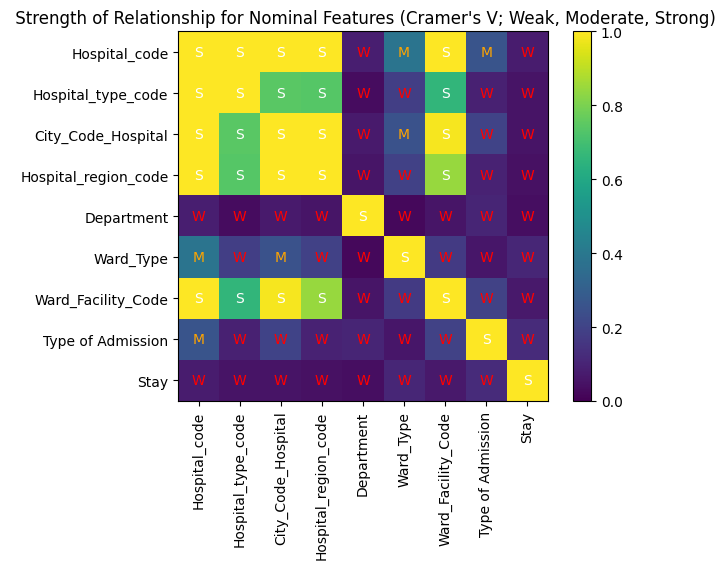

Features to remove:  ['Bed Grade', 'City_Code_Patient']


In [234]:
#Cramer's V for nominal variables
cramer_matrix   = pd.DataFrame(index=nom_cols+["Stay"], columns=nom_cols+["Stay"])          # to store Cramer's V
n = df_clean.shape[0]                                                                       # Sample size

for col1 in nom_cols+["Stay"]:
    for col2 in nom_cols+["Stay"]:
        contingency_table = pd.crosstab(df_clean[col1],df_clean[col2]) # Construct contingency table between target and each categorical var
        min_dim = min(contingency_table.shape) - 1                     # Minimum table dimension

        # Compute Cramer's V
        cramer_matrix.loc[col1, col2] = np.sqrt(chi2_matrix.loc[col1, col2].astype(float) / (n * min_dim))   
        # print( np.sqrt(chi2_matrix.loc[col1, col2] / (n * min_dim)) )
        # print( chi2_matrix.loc[col1, col2] / (n * min_dim))
        # print( chi2_matrix.loc[col1, col2])
        # print( (n * min_dim))
         
# Plot strength of relationship as heatmap
plt.imshow(cramer_matrix.astype(float), vmin=0, vmax=1, cmap='viridis')
plt.colorbar()
plt.xticks(range(len(nom_cols+["Stay"])),labels=nom_cols+["Stay"], rotation=90)
plt.yticks(range(len(nom_cols+["Stay"])),labels=nom_cols+["Stay"], rotation=0)
plt.title(" Strength of Relationship for Nominal Features (Cramer's V; Weak, Moderate, Strong)")

# Overlay the relationship value as text
for i,col1 in enumerate(nom_cols+["Stay"]):
    for j,col2 in enumerate(nom_cols+["Stay"]):
        sig = cramer_matrix.loc[col1, col2] # get significance
    
        # Annotate the heatmap
        if sig <= 0.2: # Weak assosiation
            plt.text(j, i, "W", ha='center', va='center', color='red', fontsize=10)
        elif sig <=0.6:
            plt.text(j, i, "M", ha='center', va='center', color='orange', fontsize=10)
        else:
            plt.text(j, i, "S", ha='center', va='center', color='white', fontsize=10)
            

# show plot
plt.show()
print("Features to remove: ", to_drop)

From using Cramer's V to compare the relationships of the nominal features, we see:
* "Type of Admission" and "Ward_Type" have the strongest associations to "Stay", even though the relationship is still weak.
* There are many strong relationships between the nominal features:
    *  "Hospital_code" (cardinality: 32) is very strongly related to "Ward_Facility_Code" (6), "City_Code_Hospital" (11), "Hospital_type_code" (7), "Hospital_Region_Code" (3)
    *   "Hospital_type_code" is less closely related to "Ward_Facility_Code", "City_Code_Hospital" and "Hospital_Region_Code"
    *   "Ward_Facility_Code" is less closely related to "Hospital_Region_Code" and "Hospital_type_code"

In [235]:
print("Cramer's V for significant features and Stay")
print()
print(cramer_matrix["Stay"].sort_values(ascending=False))

print()
print("Cramer's V for significant features and Hospital_code ")
print()
print(cramer_matrix["Hospital_code"].sort_values(ascending=False))

print()
print("Cramer's V for significant features and Ward_Facility_Code ")
print()
print(cramer_matrix["Ward_Facility_Code"].sort_values(ascending=False))

Cramer's V for significant features and Stay

Stay                         1.0
Type of Admission       0.123511
Ward_Type               0.107941
Hospital_code           0.075279
Ward_Facility_Code      0.068839
Hospital_type_code      0.054004
City_Code_Hospital      0.051731
Hospital_region_code    0.044036
Department              0.035476
Name: Stay, dtype: object

Cramer's V for significant features and Hospital_code 

Hospital_code                1.0
Hospital_type_code           1.0
City_Code_Hospital           1.0
Hospital_region_code         1.0
Ward_Facility_Code           1.0
Ward_Type               0.385376
Type of Admission       0.260528
Department              0.083847
Stay                    0.075279
Name: Hospital_code, dtype: object

Cramer's V for significant features and Ward_Facility_Code 

Hospital_code                1.0
Ward_Facility_Code           1.0
City_Code_Hospital      0.985432
Hospital_region_code    0.847207
Hospital_type_code      0.657622
Type of Admissi

#### Feature Selection

Looking at the Cramer's V results for nominal features:


Hospital code is the 3rd best feature but has a very high cardinality, however is very strongly related to the "Ward_Facility_Code". Using this 4th features can:
* give a proxy for the Hospital code
* reduce dimensionality 
    * removing other highly correlated variables ("City_Code_Hospital", "Hospital_region_code", "Hospital_type_code")
    * by using 6 nominal categories instead of 32 if Hospital code is used
* selecting this feature instead of Hospital code leads to a weaker relationship with the "Type_of_Admission" and "Ward_Type" features than Hospital_code has
    * this reduce redundancy, and improves generalisability of the model as models can more easily determine the impact of individual features.

The "Department" feature can also be removed to reduce dimensionality as it is the least informative feature.
    

In [236]:
print("Cramer's V for significant features and Stay after selecting most useful")
cramer_matrix.drop(["Hospital_code","City_Code_Hospital", "Hospital_region_code", "Hospital_type_code", "Department"])["Stay"].sort_values(ascending=False)

Cramer's V for significant features and Stay after selecting most useful


Stay                       1.0
Type of Admission     0.123511
Ward_Type             0.107941
Ward_Facility_Code    0.068839
Name: Stay, dtype: object

In [237]:
print("Absolute Kendall's tau values for significant features and Stay")
print()
print(kendalls_corr.drop(to_drop)["Stay"].abs().sort_values(ascending=False))

Absolute Kendall's tau values for significant features and Stay

Stay                                      1.0
Visitors with Patient                0.349825
Severity of Illness                  0.110118
Available Extra Rooms in Hospital    0.089261
Age                                  0.069873
Admission_Deposit                    0.040775
Name: Stay, dtype: object


* Prepare data set for encoding nominal features

In [238]:
# Drop columns based on feature realtionship analysis
to_drop += ["Hospital_code","City_Code_Hospital", "Hospital_region_code", "Hospital_type_code", "Department"]
df_clean.drop(to_drop, axis=1, inplace=True)

#Tidy column names
df_clean.columns = df_clean.columns.str.strip().str.lower().str.replace(' ', '_')
df_clean.columns = df_clean.columns.str.replace('department', 'dpt')
df_clean.columns = df_clean.columns.str.replace('code', 'cd')
df_clean.columns = df_clean.columns.str.replace('of_', '')
df_clean.columns = df_clean.columns.str.replace('in_', '')
df_clean.columns = df_clean.columns.str.replace('extra_', '')
df_clean.columns = df_clean.columns.str.replace('available', 'avail')

# View columns of dataframe
print(list(df_clean.columns))

['avail_rooms_hospital', 'ward_type', 'ward_facility_cd', 'type_admission', 'severity_illness', 'visitors_with_patient', 'age', 'admission_deposit', 'stay']


* Encode nominal features 

In [273]:
# Use one hot encodings to represent nominal data
nom_cols = ['ward_type', 'ward_facility_cd', 'type_admission']    
enc_cols =  pd.get_dummies(df_clean[['ward_type', 'ward_facility_cd', 'type_admission']], columns=nom_cols)

# # Append encoded nominal data to dataframe
# clean_shape = df_clean.shape # store shape of dataframe before alteration
# df_clean = pd.concat([df_clean, enc_cols], axis=1,join='inner')

# # Drop non-encoded columns
# df_clean.drop(nom_cols, axis=1, inplace=True)

# # Check dimensions are correct
# assert df_clean.shape[0] == clean_shape[0] #check rows
# assert df_clean.shape[1] > clean_shape[1] #check cols

* Check the appropriateness of bins using hierarchical clustering

(105,)


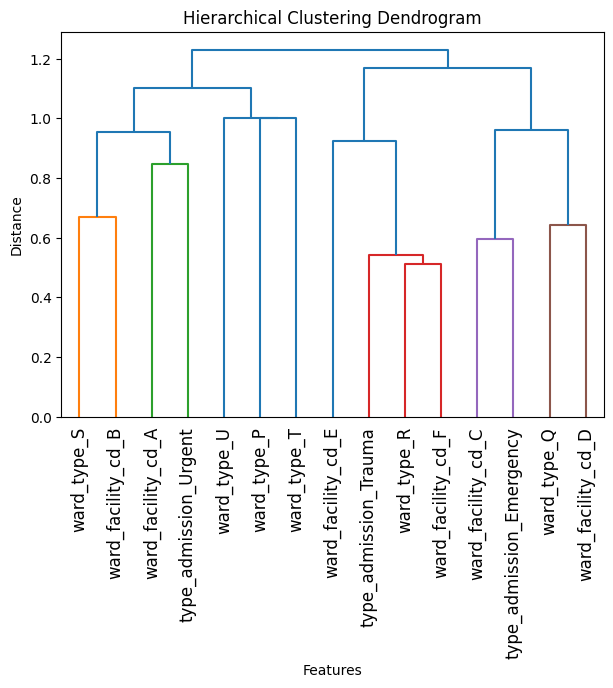

In [277]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage

# Compute the pairwise distance
distance = pdist(enc_cols.T, metric='cosine') # cosine distance
print(distance.shape)
    
# Perform hierarchical clustering 
cluster = linkage(distance, method='ward')

# Plot the dendrogram
plt.figure(figsize=(7, 5))
dendrogram(cluster, labels=enc_cols.columns, leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Features')
plt.ylabel('Distance')
plt.show()

None of the encoded features groups are highly similar (distance close to 0), so the current clusters are appropriate

## 3. Predictive Analysis

## 4. Prescriptive Analysis

## 5. Transparency & Explainability